In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [2]:
!git clone "https://github.com/srajan-kiyotaka/Pothole-Detection.git" 

Cloning into 'Pothole-Detection'...
remote: Enumerating objects: 29963, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 29963 (delta 19), reused 56 (delta 15), pack-reused 29893
Receiving objects: 100% (29963/29963), 1.29 GiB | 16.98 MiB/s, done.
Resolving deltas: 100% (1438/1438), done.
Checking out files: 100% (30027/30027), done.


In [3]:
# Importing the csv file

import pandas as pd
import numpy as np

features = pd.read_csv(r"/content/Pothole-Detection/Dataset_Info.csv")

features.head(10)

,Image ID,Pothole,Number of Potholes,Level,Unnamed: 4
0,pothole_image_1299,1,3,B,NaN
1,pothole_image_10064,1,1,A,NaN
2,pothole_image_10079,1,1,A,NaN
3,pothole_image_10084,1,1,A,NaN
4,pothole_image_10087,1,2,A,NaN
5,pothole_image_10110,1,1,A,NaN
6,pothole_image_10119,1,1,A,NaN
7,pothole_image_10120,1,1,A,NaN
8,pothole_image_10135,1,1,A,NaN
9,pothole_image_10139,1,1,A,NaN


In [4]:
features.isna().sum()

Image ID                  0
Pothole                   0
Number of Potholes        0
Level                     0
Unnamed: 4            30000
dtype: int64

In [5]:
features = features.drop('Unnamed: 4', axis = 1)

In [6]:
features.head(10)

,Image ID,Pothole,Number of Potholes,Level
0,pothole_image_1299,1,3,B
1,pothole_image_10064,1,1,A
2,pothole_image_10079,1,1,A
3,pothole_image_10084,1,1,A
4,pothole_image_10087,1,2,A
5,pothole_image_10110,1,1,A
6,pothole_image_10119,1,1,A
7,pothole_image_10120,1,1,A
8,pothole_image_10135,1,1,A
9,pothole_image_10139,1,1,A


In [7]:
features.isna().sum()

Image ID              0
Pothole               0
Number of Potholes    0
Level                 0
dtype: int64

In [8]:
all_image_names = features['Image ID']
features = features.drop('Image ID', axis = 1)

pothole_or_not = features['Pothole']
pothole_info = features['Number of Potholes']
pothole_level = features['Level']

pothole_or_not = pd.get_dummies(pothole_or_not, columns = ['Pothole'])
pothole_or_not.columns = ['Normal Road', 'Pothole']
pothole_level = pd.get_dummies(pothole_level, columns = ['Level'])

features = pothole_or_not.join(pothole_info)
features = features.join(pothole_level)

print(features.head(10))

   Normal Road  Pothole  Number of Potholes  A  B  C  S
0            0        1                   3  0  1  0  0
1            0        1                   1  1  0  0  0
2            0        1                   1  1  0  0  0
3            0        1                   1  1  0  0  0
4            0        1                   2  1  0  0  0
5            0        1                   1  1  0  0  0
6            0        1                   1  1  0  0  0
7            0        1                   1  1  0  0  0
8            0        1                   1  1  0  0  0
9            0        1                   1  1  0  0  0


In [9]:
from sklearn.utils import shuffle

image_names_shuffled, labels_shuffled = shuffle(all_image_names, features)

In [10]:
from sklearn.model_selection import train_test_split

X_train_image_names, X_test_image_names, y_train, y_test = train_test_split(
    image_names_shuffled, labels_shuffled, test_size=0.3, random_state=1)

In [11]:
type(y_train)

pandas.core.frame.DataFrame

In [12]:
train_pothole_or_not = y_train[['Normal Road', 'Pothole']]
train_pothole_info = y_train['Number of Potholes']
train_pothole_level = y_train[['A', 'B', 'C', 'S']]

test_pothole_or_not = y_test[['Normal Road', 'Pothole']]
test_pothole_info = y_test['Number of Potholes']
test_pothole_level = y_test[['A', 'B', 'C', 'S']]

In [13]:
y_train.shape

(21000, 7)

In [14]:
train_pothole_or_not = np.array(train_pothole_or_not)
train_pothole_info = np.array(train_pothole_info)
train_pothole_level = np.array(train_pothole_level)

test_pothole_or_not = np.array(test_pothole_or_not)
test_pothole_info = np.array(test_pothole_info)
test_pothole_level = np.array(test_pothole_level)

In [15]:
import cv2

def get_image(file_location):
    img = cv2.imread(file_location)
    # img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # img = img/255
    img = cv2.resize(img,(160, 160))
    return img

In [16]:
import keras
import numpy as np

class My_Custom_Generator(keras.utils.all_utils.Sequence) :
  
  def __init__(self, image_filenames, pothole, pothole_number, pothole_level, batch_size = 128) :
    self.image_filenames = image_filenames
    self.pothole = pothole
    self.pothole_number = pothole_number
    self.pothole_level = pothole_level
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    a = self.pothole[idx * self.batch_size : (idx+1) * self.batch_size]
    # b = self.pothole_number[idx * self.batch_size : (idx+1) * self.batch_size]
    c = self.pothole_level[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = [np.array(a), np.array(c)] #, np.array(c)]

    return np.array([
            get_image(f'/content/Pothole-Detection/Unified Dataset/{str(file_name)}.jpg')
               for file_name in batch_x]), batch_y

In [17]:
batch_size = 75

my_training_batch_generator = My_Custom_Generator(X_train_image_names, train_pothole_or_not, train_pothole_info, train_pothole_level, batch_size)
my_validation_batch_generator = My_Custom_Generator(X_test_image_names, test_pothole_or_not, test_pothole_info, test_pothole_level, batch_size)

In [18]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, Activation, Add, BatchNormalization, Rescaling

input_ = Input(shape = (160, 160, 3), name = "Input Layer")

rescale = Rescaling(scale=1./255)(input_)

conv_1 = Conv2D(64, kernel_size = (8, 8), name = "conv_1")(rescale)
act_1 = Activation("relu", name = "act_1")(conv_1)
pool_1 = MaxPooling2D(pool_size = (8, 8), strides = (1, 1), padding = "valid", name = "pool_1")(act_1)

conv_2 = Conv2D(32, kernel_size = (2, 2), name = "conv_2")(pool_1)
act_2 = Activation("relu", name = "act_2")(conv_2)
pool_2 = MaxPooling2D(pool_size = (8, 8), strides = (1, 1), padding = "valid", name = "pool_2")(act_2)

conv_3 = Conv2D(16, kernel_size = (4, 4), name = "conv_3")(pool_2)
act_3 = Activation("relu", name = "act_3")(conv_3)
pool_3 = MaxPooling2D(pool_size = (16, 16), strides = (1, 1), padding = "valid", name = "pool_3")(act_3)

flat_1 = Flatten(name = "flat_1")(pool_3)

dense_1 = Dense(128, activation = "relu", name = "dense_1")(flat_1)
batch_1 = BatchNormalization(name = "batch_1")(dense_1)
dense_2 = Dense(64, activation = "relu", name = "dense_2")(batch_1)
batch_2 = BatchNormalization(name = "batch_2")(dense_2)
dense_3 = Dense(32, activation = "relu", name = "dense_3")(batch_2)
isPothole = Dense(2, activation = "softmax", name = "pothole")(dense_3)

conv_4 = Conv2D(8, kernel_size = (4, 4), name = "conv_4")(pool_3)
act_4 = Activation("relu", name = "act_4")(conv_4)
pool_4 = MaxPooling2D(pool_size = (8, 8), strides = (1, 1), padding = "valid", name = "pool_4")(act_4)

# flat_2 = Flatten(name = "flat_2")(pool_4)

# dense_4 = Dense(128, activation = "relu", name = "dense_4")(flat_2)
# batch_3 = BatchNormalization(name = "batch_3")(dense_4)
# add_1 = Add(name = "add_1")([batch_1, batch_3])

# dense_5 = Dense(64, activation = "relu", name = "dense_5")(add_1)
# batch_4 = BatchNormalization(name = "batch_4")(dense_5)
# pothole_num = Dense(1, activation = "relu", name = "pothole_number")(batch_2)

# conv_5 = Conv2D(16, kernel_size = (8, 8), name = "conv_5")(pool_4)
# act_5 = Activation("relu", name = "act_5")(conv_5)
# pool_5 = MaxPooling2D(pool_size = (4, 4), strides = (1, 1), padding = "valid", name = "pool_5")(act_5)

flat_2 = Flatten(name = "flat_2")(pool_4)

dense_4 = Dense(128, activation = "relu", name = "dense_4")(flat_2)
batch_5 = BatchNormalization(name = "batch_5")(dense_4)
add_2 = Add(name = "add_2")([batch_1, batch_5])
batch_6 = BatchNormalization(name = "batch_6")(add_2)
dense_5 = Dense(64, activation = "relu", name = "dense_5")(batch_6)
drop_2 = Dropout(rate = 0.4, name = "drop_2")(dense_5)
# add_3 = Add(name = "add_3")([batch_7, batch_2])
dense_6 = Dense(32, activation = "relu", name = "dense_6")(drop_2)
batch_7 = BatchNormalization(name = "batch_7")(dense_6)
dense_7 = Dense(16, activation = "relu", name = "dense_7")(batch_7)
drop_3 = Dropout(rate = 0.4, name = "drop_3")(dense_7)
dense_8 = Dense(8, activation = "relu", name = "dense_8")(drop_3)
pothole_level = Dense(4, activation = "softmax", name = "pothole_level")(dense_8)

model = Model(inputs = input_, outputs = [isPothole, pothole_level])

opt = tf.keras.optimizers.SGD(learning_rate = 0.001)

model.compile(
              loss = {
                  'pothole' : 'categorical_crossentropy',
                #   'pothole_number' : 'categorical_crossentropy'
                  'pothole_level' : 'categorical_crossentropy'
              },
              optimizer = opt,
              metrics = ['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input Layer (InputLayer)       [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['Input Layer[0][0]']            
                                                                                                  
 conv_1 (Conv2D)                (None, 153, 153, 64  12352       ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

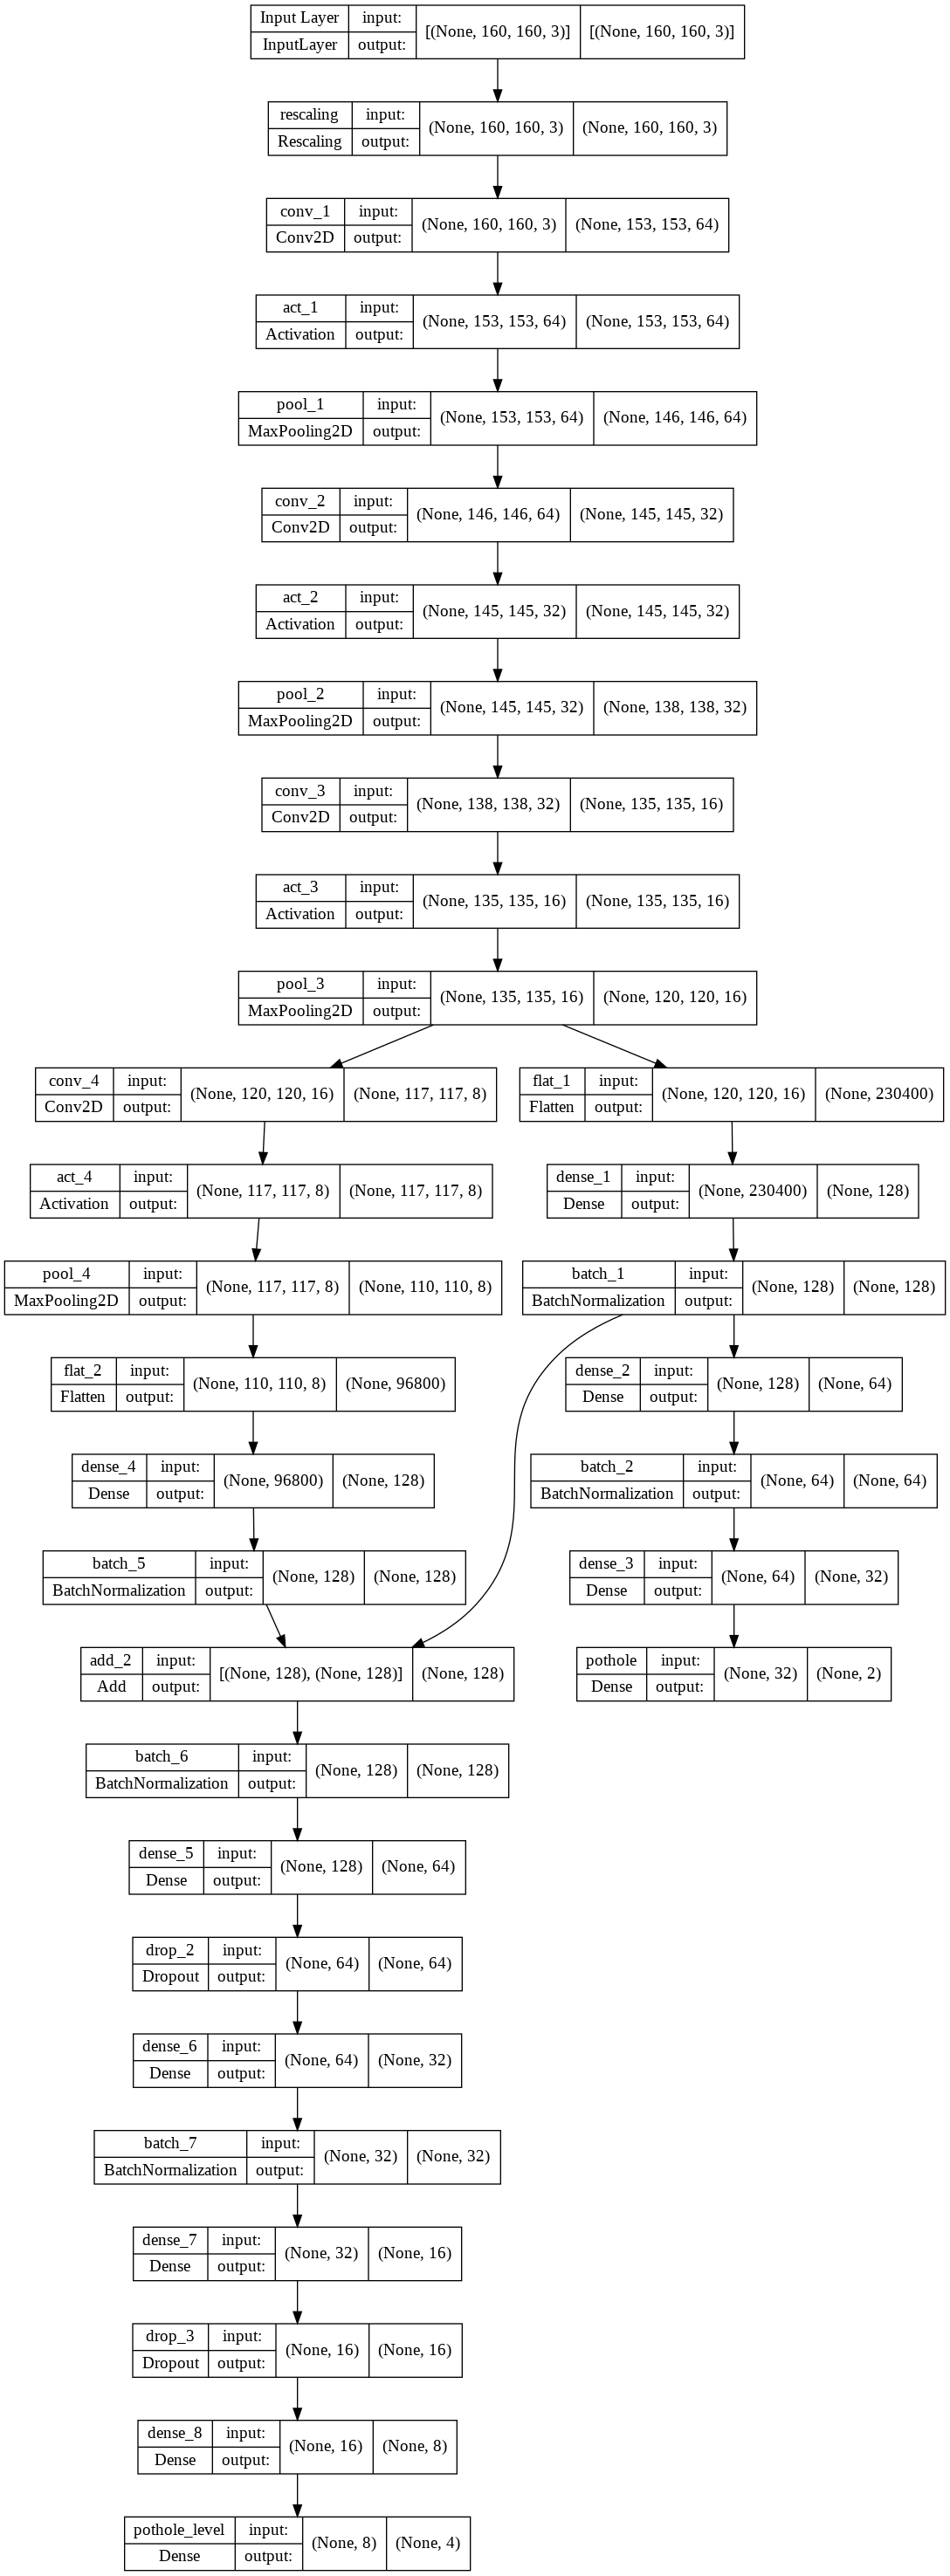

In [19]:
keras.utils.all_utils.plot_model(model, "model.png", show_shapes = True, show_layer_names = True)

In [20]:
# class Logger(keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     pothole_accuracy = logs.get('pothole_accuracy')
#     pothole_number_accuracy = logs.get('pothole_number_accuracy')
#     pothole_level_accuracy = logs.get('pothole_level_accuracy')

#     val_pothole_accuracy = logs.get('val_pothole_accuracy')
#     val_pothole_number_accuracy = logs.get('val_pothole_number_accuracy')
#     val_pothole_level_accuracy = logs.get('val_pothole_level_accuracy')

#     print('='*30, epoch + 1, '='*30)
#     print(f'pothole_accuracy: {pothole_accuracy:.2f}, pothole_number_accuracy: {pothole_number_accuracy:.2f}, pothole_level_accuracy: {pothole_level_accuracy:.2f}')
#     print(f'val_pothole_accuracy: {val_pothole_accuracy:.2f}, val_pothole_number_accuracy: {val_pothole_number_accuracy:.2f}, val_pothole_level_accuracy:{val_pothole_level_accuracy:.2f}')

In [21]:
_ = model.fit_generator(generator=my_training_batch_generator,
                   steps_per_epoch = int(21000 // batch_size),
                   epochs = 44,
                #    verbose = False,
                   validation_data = my_validation_batch_generator,
                #    callbacks = [
                #                 Logger(),
                #                 keras.callbacks.TensorBoard(log_dir = './logs')
                #                 ],
                   validation_steps = int(9000 // batch_size))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


Epoch 1/44
280/280 [==============================] - 150s 476ms/step - loss: 1.9481 - pothole_loss: 0.3412 - pothole_level_loss: 1.6068 - pothole_accuracy: 0.8712 - pothole_level_accuracy: 0.2015 - val_loss: 1.6490 - val_pothole_loss: 0.4018 - val_pothole_level_loss: 1.2473 - val_pothole_accuracy: 0.8613 - val_pothole_level_accuracy: 0.7354
Epoch 2/44
280/280 [==============================] - 132s 472ms/step - loss: 1.5090 - pothole_loss: 0.2758 - pothole_level_loss: 1.2333 - pothole_accuracy: 0.9006 - pothole_level_accuracy: 0.5596 - val_loss: 1.3655 - val_pothole_loss: 0.3380 - val_pothole_level_loss: 1.0275 - val_pothole_accuracy: 0.8704 - val_pothole_level_accuracy: 0.8164
Epoch 3/44
280/280 [==============================] - 133s 473ms/step - loss: 1.2747 - pothole_loss: 0.2539 - pothole_level_loss: 1.0208 - pothole_accuracy: 0.9066 - pothole_level_accuracy: 0.7434 - val_loss: 1.2420 - val_pothole_loss: 0.3811 - val_pothole_level_loss: 0.8610 - val_pothole_accuracy: 0.8372 - val

In [22]:
# model.save("/content/gdrive/MyDrive/pothole_detection_model_prototype_3_sgd.h5")

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()
open("/content/gdrive/MyDrive/pothole_detection_model_prototype_4_sgd.tflite" , "wb").write(tflite_model_quant)

41952976

In [24]:
# import tensorflow as tf

# model = tf.keras.models.load_model('/content/gdrive/MyDrive/A_I/pothole_detection_model_prototype_1_adam.h5')
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()
# open("/content/gdrive/MyDrive/A_I/pothole_detection_model_prototype_1_adam.tflite", "wb").write(tflite_model)